# AeroGraphNet inference (Ahmed Body)

This notebook uses the [PhysicsNeMo AeroGraphNet checkpoint](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/models/modulus_ahmed_body_meshgraphnet) to run inference on different Ahmed bodies. The training code and documentation for this checkpoint/model can be found on the GitHub repo [here](https://github.com/NVIDIA/physicsnemo/tree/main/examples/cfd/external_aerodynamics/aero_graph_net/). 

This notebook will use the model that was trained on a dataset of Ahmed bodies of various sizes to infer results and perform some scientific analysis on unseen Ahmed body like geometries. 

## Running Inference

This notebook will use the `AhmedBodyDataset` util from PhysicsNeMo and DGL's `GraphDataLoader` to prepare and load the data. 

The inputs to the model are:
* Ahmed body surface mesh
* Reynolds number
* Geometry parameters (optional, including length, width, height, ground clearance, slant angle, and fillet radius)
* surface normals (optional)

Output of the model are:
* Surface pressure
* Wall shear stresses

The input to the model is in form of a `.vtp` file and is then converted to bi-directional DGL graphs in the dataloader. The final results are also written in the form of `.vtp` files.

Let's begin by first downloading the model package.

In [2]:
from pathlib import Path

if Path("ahmed_body_mgn.zip").is_file():
    pass
else:
    !wget 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_ahmed_body_meshgraphnet/versions/v0.2/files/ahmed_body_mgn.zip'
    !unzip ahmed_body_mgn.zip
    !mv ahmed_body_mgn/* .
    !rm utils.py # TODO: hacky, remove the old utils.py

--2024-08-28 01:38:28--  https://api.ngc.nvidia.com/v2/models/nvidia/physicsnemo/modulus_ahmed_body_meshgraphnet/versions/v0.2/files/ahmed_body_mgn.zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.68.220.33, 52.35.221.76
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.68.220.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/physicsnemo/models/modulus_ahmed_body_meshgraphnet/versions/v0.2/files/ahmed_body_mgn.zip?versionId=XNzIKS7EVoVHI66Hl7K1JcerYY6Y2Wpx&Expires=1724895508&Signature=f1qkIn~epHOJtTbRc08lWjCWPLp~WC9IkaUcj9YCDUAtqHrXPCvSzhwGQlF-pet4B1FdCenN-wv5KAKcLxpc~3-MQzPrUMgab~~yT3pgs3vUJiwgNFrZlwf~rePNbl-zWXp5Ky5bJahke0HVFbVKF8EOFsCg-gD78EzCcwXVJ5oF6mw5K-E5OzGHv3v71faWy0ktIBiOLtRP4Th-AMi2Yb7eXlxwwxiqdFbmyHaPq28QTn6NF8ltjrbON39uAIBANn8d-jf9whY5lmYnTWGaNIg6lNCt6jnXCawj1XhKRIHYpR3zRX-pXNeKNJr51Y3gyDPr3wjb0nnlrC9t7T8g7w__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-08-28 01:38:28--  https:/

We can see that the model checkpoint in the `checkpoints` folder under the name `MeshGraphNet.0.499.mdlus`. We also have a few sample dataset to do the inference on inside the `dataset` directory. Let's start with a few imports

In [3]:
import torch
import numpy as np
import wandb as wb
from torch.cuda.amp import autocast, GradScaler
from physicsnemo.models.meshgraphnet import MeshGraphNet
from physicsnemo.datapipes.gnn.ahmed_body_dataset import AhmedBodyDataset
from physicsnemo.launch.utils import load_checkpoint
from physicsnemo.launch.logging import PythonLogger

from dgl.dataloading import GraphDataLoader
from dgl import DGLGraph
import pyvista as pv


/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-28 01:38:40.605739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 01:38:41.735073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Let's write a few helper functions. The model output is a DGL graph of the 3D geometry which might be difficult to visualize. Here, we will define a function that converts this `DGLGraph` object to a PyVista graph which can be saved as a `.vtp` or `.vtk` file to be visualized using tools like ParaView or pythonically using PyVista. 

In [4]:
def dgl_to_pyvista(graph: DGLGraph):
    """
    Converts a DGL graph to a PyVista graph.

    Parameters:
    -----------
    graph: DGLGraph
        The input DGL graph.

    Returns:
    --------
    pv_graph:
        The output PyVista graph.
    """

    # Convert the DGL graph to a NetworkX graph
    nx_graph = graph.to_networkx(
        node_attrs=["pos", "p_pred", "p", "s_pred", "wallShearStress"]
    ).to_undirected()

    # Initialize empty lists for storing data
    points = []
    lines = []
    p_pred = []
    s_pred = []
    p = []
    wallShearStress = []

    # Iterate over the nodes in the NetworkX graph
    for node, attributes in nx_graph.nodes(data=True):
        # Append the node and attribute data to the respective lists
        points.append(attributes["pos"].numpy())
        p_pred.append(attributes["p_pred"].numpy())
        s_pred.append(attributes["s_pred"].numpy())
        p.append(attributes["p"].numpy())
        wallShearStress.append(attributes["wallShearStress"].numpy())

    # Add edges to the lines list
    for edge in nx_graph.edges():
        lines.extend([2, edge[0], edge[1]])

    # Initialize a PyVista graph
    pv_graph = pv.PolyData()

    # Assign the points, lines, and attributes to the PyVista graph
    pv_graph.points = np.array(points)
    pv_graph.lines = np.array(lines)
    pv_graph.point_data["p_pred"] = np.array(p_pred)
    pv_graph.point_data["s_pred"] = np.array(s_pred)
    pv_graph.point_data["p"] = np.array(p)
    pv_graph.point_data["wallShearStress"] = np.array(wallShearStress)

    return pv_graph

Next, let's write some steps to load the data and compute the model inference. This portion can be briefly broken down into three major steps, load the data, instantiate the model and load the trained weights and finally compute the model inference on the data. 

In [5]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils import relative_lp_error


class AhmedBodyRollout:
    def __init__(self, wb, logger):
        # set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        logger.info(f"Using {self.device} device")

        # instantiate dataset
        self.dataset = AhmedBodyDataset(
            name="ahmed_body_test",
            data_dir="./dataset",
            split="test",
            num_samples=4,
            compute_drag=True,
        )

        # instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,
            shuffle=False,
            drop_last=False,
        )

        # instantiate the model
        self.model = MeshGraphNet(
            11,
            4,
            4,
            aggregation="sum",
            hidden_dim_node_encoder=256,
            hidden_dim_edge_encoder=256,
            hidden_dim_node_decoder=256,
        )
        self.model = self.model.to(self.device)
        self.scaler = GradScaler()

        # enable train mode
        self.model.eval()

        self.model.load("./checkpoints/ahmed_body/MeshGraphNet.0.499.mdlus")

    def predict(self, save_results=False):
        """
        Run the prediction process.

        Parameters:
        -----------
        save_results: bool
            Whether to save the results in form of a .vtp file, by default False


        Returns:
        --------
        None
        """

        self.pred, self.exact, self.faces, self.graphs = [], [], [], []

        for i, (graph, sid, normals, areas, coeff) in enumerate(self.dataloader):
            graph = graph.to(self.device)
            normals = normals.to(self.device, torch.float32).squeeze()
            areas = areas.to(self.device, torch.float32).squeeze()
            coeff = coeff.to(self.device, torch.float32).squeeze()
            sid = sid.item()
            logger.info(f"Processing sample ID {sid}")
            pred = self.model(graph.ndata["x"], graph.edata["x"], graph).detach()

            gt = graph.ndata["y"]
            graph.ndata["p_pred"] = pred[:, 0]
            graph.ndata["s_pred"] = pred[:, 1:]
            graph.ndata["p"] = gt[:, 0]
            graph.ndata["wallShearStress"] = gt[:, 1:]

            error = relative_lp_error(pred, gt)
            logger.info(f"Test error (%): {error}")

            if save_results:
                # Convert DGL graph to PyVista graph and save it
                os.makedirs("./results_nbk", exist_ok=True)
                pv_graph = dgl_to_pyvista(graph.cpu())
                pv_graph.save(os.path.join("./results_nbk", f"graph_{sid}.vtp"))


logger = PythonLogger("main")  # General python logger
logger.file_logging()

logger.info("Rollout started...")
rollout = AhmedBodyRollout(wb, logger)
rollout.predict(save_results=True)

/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-28 01:39:02.960107: I tensorflow/core/platform/cpu_feature_guard.cc:

## Post Processing

Once the results are written, we can visualize them using `pymesh`. This might require installing a few additional dependencies, which can be done by uncommenting the below code block.  

In [6]:
# %%capture
# !apt install -y libgl1-mesa-glx xvfb

Once you have verified that you have the right dependencies, the results can be visualized by running the following

/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


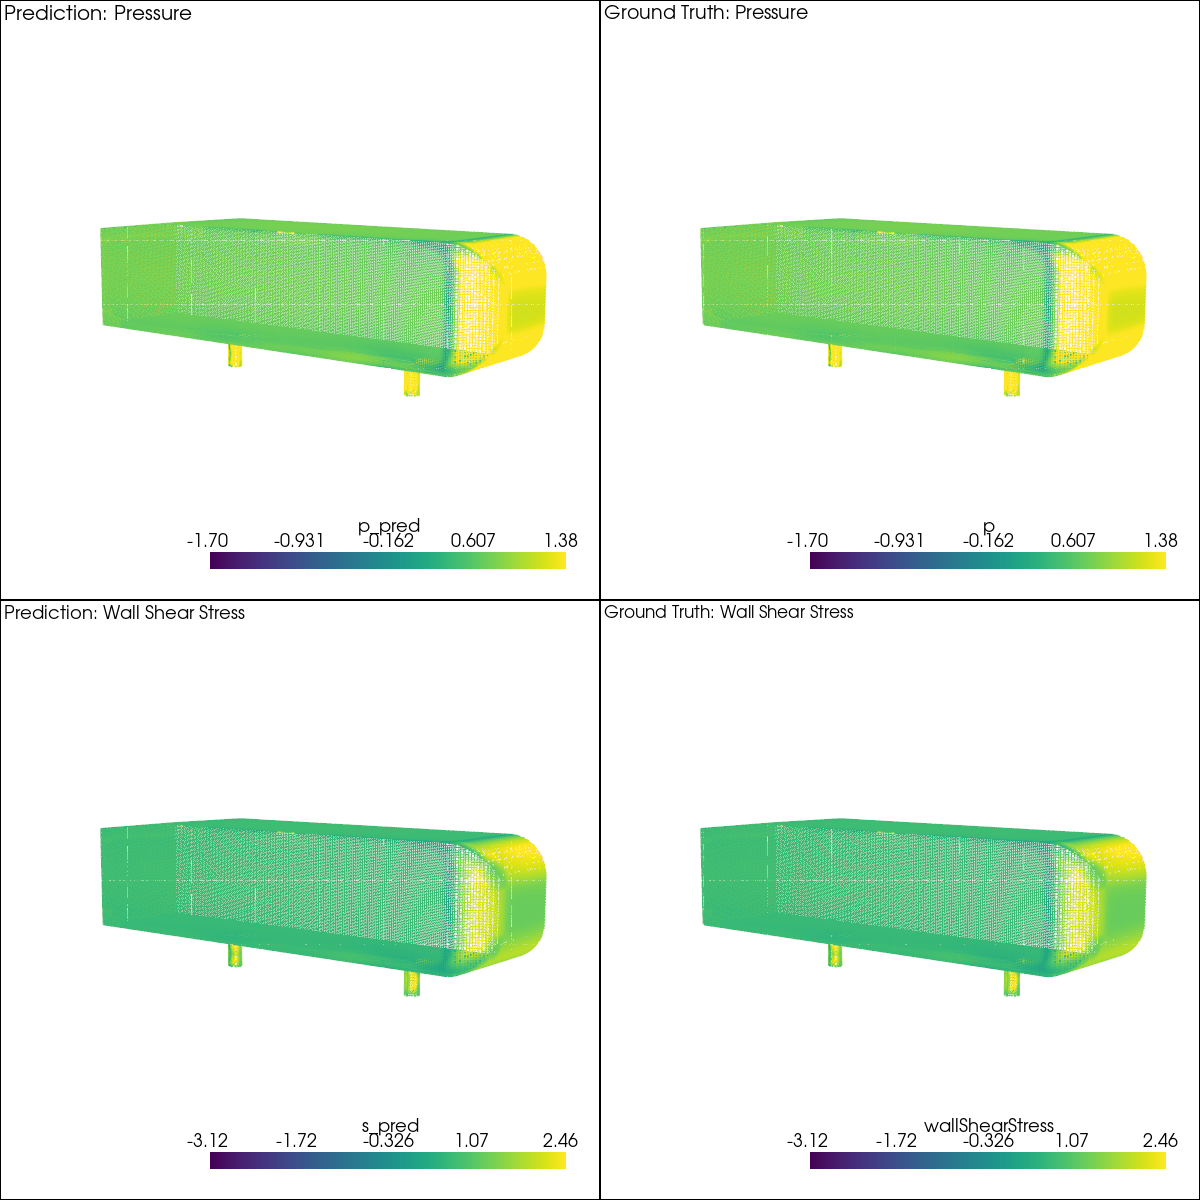

In [7]:
import pyvista as pv
import numpy as np

pv.start_xvfb()

camera_position = [(-2.0, 2.0, 0.5), (-0.5, 0.12225, 0.15775), (0, 0, 1)]

result = pv.read("./results_nbk/graph_27.vtp")

p_min = result.point_data["p_pred"].min()
p_max = result.point_data["p_pred"].max()
s_min = result.point_data["s_pred"].min()
s_max = result.point_data["s_pred"].max()

plotter = pv.Plotter(shape=(2, 2), window_size=(1200, 1200))

plotter.subplot(0, 0)
plotter.add_mesh(result, scalars="p_pred", clim=[p_min, p_max])
plotter.add_text("Prediction: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(0, 1)
plotter.add_mesh(result, scalars="p", clim=[p_min, p_max])
plotter.add_text("Ground Truth: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 0)
plotter.add_mesh(result, scalars="s_pred", clim=[s_min, s_max])
plotter.add_text("Prediction: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 1)
plotter.add_mesh(result, scalars="wallShearStress", clim=[s_min, s_max])
plotter.add_text("Ground Truth: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.show()

As you can notice, the predictions of the model match well with the ground truth results. 

As one can notice, the current output only provides wireframe output and lacks cell data. In the subsequent steps, we will resample the wireframe data onto a mesh to get more smoother visualization. This will also enable us to compute the surface averaged quantities such as drag coefficients with more accuracy. 

**Note:** To demonstrate this, a sample mesh which contains the cell data has been provided in the package.

/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


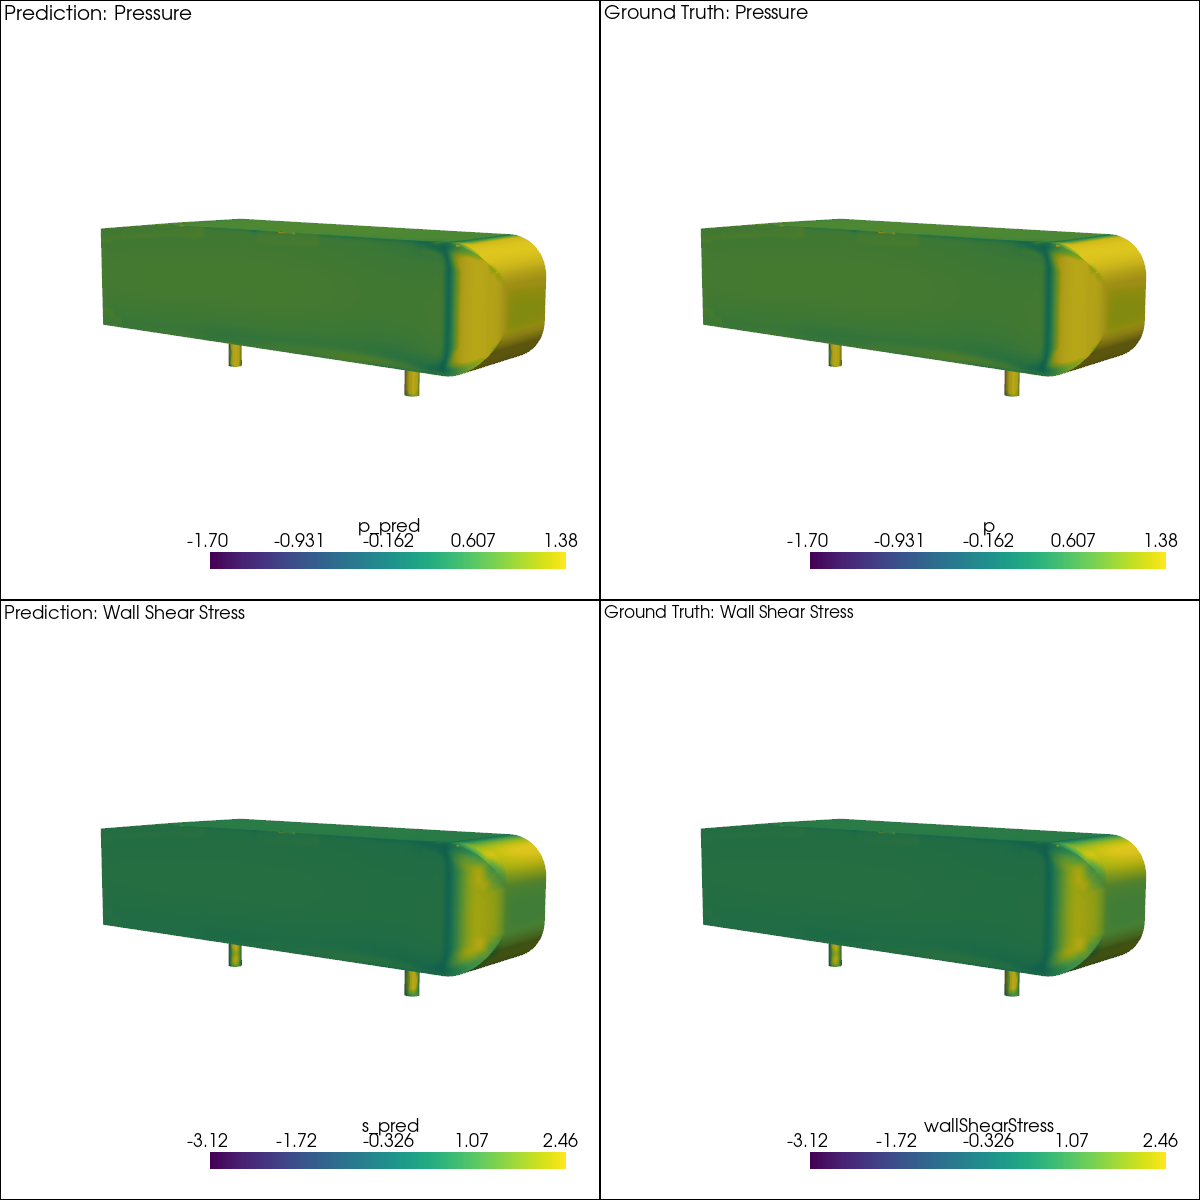

In [8]:
import pyvista as pv
import numpy as np

pv.start_xvfb()

mesh = pv.read("./case27_surface_mesh.vtp")
camera_position = [(-2.0, 2.0, 0.5), (-0.5, 0.12225, 0.15775), (0, 0, 1)]

data_to_probe = pv.read("./results_nbk/graph_27.vtp")
result = mesh.sample(data_to_probe)

p_min = result.point_data["p_pred"].min()
p_max = result.point_data["p_pred"].max()
s_min = result.point_data["s_pred"].min()
s_max = result.point_data["s_pred"].max()

plotter = pv.Plotter(shape=(2, 2), window_size=(1200, 1200))

plotter.subplot(0, 0)
plotter.add_mesh(result, scalars="p_pred", clim=[p_min, p_max])
plotter.add_text("Prediction: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(0, 1)
plotter.add_mesh(result, scalars="p", clim=[p_min, p_max])
plotter.add_text("Ground Truth: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 0)
plotter.add_mesh(result, scalars="s_pred", clim=[s_min, s_max])
plotter.add_text("Prediction: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 1)
plotter.add_mesh(result, scalars="wallShearStress", clim=[s_min, s_max])
plotter.add_text("Ground Truth: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.show()

### Computing Drag Coefficient

An important metric in aerodynamic analysis is drag coefficient. Prediction of accurate drag coefficient has implications on vehicle performance and efficiency. In the subsequent sections, we will compute the drag coefficient for this Ahmed body configuration. To compute that, we would need to compute the surface area at each cell, compute the cell normals and project the point-data to cells. This can be done using below

In [9]:
result = result.point_data_to_cell_data()
result = result.compute_normals()
result = result.compute_cell_sizes()
result

PolyData (0x7f306d638040)
  N Cells:    70805
  N Points:   71174
  N Strips:   0
  X Bounds:   -1.019e+00, -9.082e-17
  Y Bounds:   0.000e+00, 2.445e-01
  Z Bounds:   0.000e+00, 3.155e-01
  N Arrays:   15

In [10]:
import json

from physicsnemo.metrics.cae.cfd import compute_force_coefficients, compute_frontal_area

# Load the stats to denormalize the data
f = open("node_stats.json")
stats = json.load(f)

# Load case info to read velocity and relevant info
data = np.loadtxt("./dataset/test_info/case27_info.txt", usecols=(2), max_rows=7)
velocity = data[-1]

p_true = result.cell_data["p"] * stats["p_std"] + stats["p_mean"]
p_pred = result.cell_data["p_pred"] * stats["p_std"] + stats["p_mean"]
wss_true = (
    result.cell_data["wallShearStress"] * stats["wallShearStress_std"]
    + stats["wallShearStress_mean"]
)
wss_pred = (
    result.cell_data["s_pred"] * stats["wallShearStress_std"]
    + stats["wallShearStress_mean"]
)

frontal_area = compute_frontal_area(result, direction="x")
normals = result.cell_data["Normals"]
areas = result.cell_data["Area"]

coeff = 2 / (frontal_area * 1.225 * velocity**2)

cd_true, _, _ = compute_force_coefficients(normals, areas, coeff, p_true, wss_true, np.array([1, 0, 0]))
cd_pred, _, _ = compute_force_coefficients(normals, areas, coeff, p_pred, wss_pred, np.array([1, 0, 0]))

print(cd_true, cd_pred)

0.2307369133818469 0.2055278006286764


This completes the inference analysis for the Ahmed body checkpoint. 